In [16]:
# TODO: Creare interfaccia web

# Ngrok test
# !pip install flask pyngrok

# from flask import Flask
# from pyngrok import ngrok
# ngrok.set_auth_token("1xtk0FocXBZ2vuYvDaSGF6FrsTV_72TgyCXjkUvCrhXJGr5qQ")

# app = Flask(__name__)

# @app.route('/')
# def index():
#     return "<h1>Ciao bro</h1>"

# @app.route('/cicciogamer')
# def ciccio():
#     return "<h1>Ciao ciccio</h1>"

# tunnel = ngrok.connect(5000)
# print(" * Tunnel URL:", tunnel.public_url)

# app.run(host='0.0.0.0', port=5000, use_reloader=False)

# Predizione dei voti degli esami di uno studente
## Programmazione di Applicazioni Data intensive
Laurea di Ingegneria e Scienze Informatiche
### Partecipanti:
- Dani
- Luca
- Lore


# Librerie e import utilizzati

In [2]:
# Base libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd

# Matplotlib - jupyter compatibility
%matplotlib inline

# Sklearn model utilities
import sklearn as skl
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

# XGBoost model utilities
from xgboost import XGBRegressor

import kagglehub as kaggle # To download data from kaggle

pd.set_option('display.max_rows', 500)

c:\Users\palaz\Desktop\AISISIDF\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Descrizione del problema
Il dataset preso da noi in considerazione, contiene dati riguardanti degli studenti, le loro situazioni accademiche, abitudini e status di salute mentale.

Il nostro obiettivo é quello di riuscire a predire il voto dell'esame finale in base ad alcune delle caratteristiche riguardo ad uno studente.

# Parte I - Analisi dei dati

## Caricamento dei dati

In [3]:
# Scarica i file da kaggle
kaggle_base_path: str = kaggle.dataset_download("tuannguyenvananh/pokemon-dataset-with-team-combat")
# Caricamento dei vari dataframe del dataset
combat_file_path: str = kaggle_base_path + '/combats.csv'
pokemon_file_path: str = kaggle_base_path + '/pokemon.csv'
team_combat_file_path: str = kaggle_base_path + '/team_combat.csv'
team_file_path: str = kaggle_base_path + '/pokemon_id_each_team.csv'
dataset_pokemon: pd.DataFrame = pd.read_csv(pokemon_file_path)
dataset_teams: pd.DataFrame = pd.read_csv(team_file_path)
dataset_combat: pd.DataFrame = pd.read_csv(combat_file_path)
dataset_team_combat: pd.DataFrame = pd.read_csv(team_combat_file_path)

# Settaggio degli id delle tabelle
dataset_pokemon.set_index('#', inplace=True)
dataset_teams.set_index('#', inplace=True)

In [4]:
dataset_1v1_fights: pd.DataFrame = dataset_combat \
    .join(dataset_pokemon, on="First_pokemon", how="inner", rsuffix=' First') \
    .join(dataset_pokemon, on="Second_pokemon", how="inner", rsuffix=' Second') \
    .drop(columns=["Name", "Name Second", "Generation", "Generation Second"])

In [5]:
dataset_1v1_fights.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   First_pokemon     50000 non-null  int64 
 1   Second_pokemon    50000 non-null  int64 
 2   Winner            50000 non-null  int64 
 3   Type 1            50000 non-null  object
 4   Type 2            25969 non-null  object
 5   HP                50000 non-null  int64 
 6   Attack            50000 non-null  int64 
 7   Defense           50000 non-null  int64 
 8   Sp. Atk           50000 non-null  int64 
 9   Sp. Def           50000 non-null  int64 
 10  Speed             50000 non-null  int64 
 11  Legendary         50000 non-null  bool  
 12  Type 1 Second     50000 non-null  object
 13  Type 2 Second     26015 non-null  object
 14  HP Second         50000 non-null  int64 
 15  Attack Second     50000 non-null  int64 
 16  Defense Second    50000 non-null  int64 
 17  Sp. Atk Seco

## Significato dei dati
TODO: Magari dovremmo descrivere quali variabili sono piú "importanti" e quali variabili sono da sistemare?

Tutti questi dati sono relativi ad un singolo studente.
- `age`: l'etá.
- `gender`: il genere (Male, female o Other).
- `major`: il campo di studio.
- `study_hours_per_day`: media di ore di studio al giorno.
- `social_media_hours`: quantitá di ore spese su social media (al giorno).
- `netflix_hours`: quantitá di ore spese su netflix (al giorno)
- `part_time_job`: indica se uno studente ha un lavoro part time (Yes/No).
- `attendance_percentage`: percentuale di ore partecipate a lezione.
- `sleep_hours`: media di ore dormite al giorno.
- `diet_quality`: qualitá della dieta di uno studente (Good, Fair, Poor).
- `exercise_frequency`: numero di sessioni di esercizio fisico a settimana.
- `parental_education_level`: massimo grado di educazione dei genitori.
- `internet_quality`: qualitá di internet (High, Medium, Low).
- `mental_health_rating`: sanitá mentale dello studente, autovalutato (scala da 1-10)
- `extracurricular_participation`: indica se uno studente partecipa ad attivitá extracurricolari (Yes/No)
- `previous_gpa`: GPA del semestre scorso (scala da 1.5-4.0)
- `semester`: il semestre attuale.
- `stress_level`: il livello di stress dello studente, autovalutato (scala da 1-10)
- `dropout_risk`: indica il rischio che uno studente possa lasciare l'universitá.
- `social_activity`: numero di eventi sociali a cui ha partecipato.
- `screen_time`: quantitá di ore spese davanti ad uno schermo (somma di tempo di studio, netflix e social media).
- `study_environment`: luogo di studio preferito.
- `access_to_tutoring`: indica se lo studente ha accesso a supporto da tutor (Yes/No)
- `family_income_range`: range di guadagno dei genitori (High, Medium, Low).
- `parental_support_level`: livello di supporto parentale, autovalutato (scala da 1-10).
- `motivation_level`: livello di motivazione dello studente, autovalutato (scala da 1-10).
- `exam_anxiety_score`: livelli di ansia relativi ad esami, autovalutato (scala da 1-10).
- `learning_style`: modalitá di studio preferita dallo studente.
- `time_management_score`: bravura nella gestione del tempo, autovalutato (scala da 1-10).
- `exam_score`: punteggio dell'esame finale (scala da 0-100).

## Esplorazione dei dati

In [6]:
dataset_1v1_fights.describe()

,First_pokemon,Second_pokemon,Winner,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,HP Second,Attack Second,Defense Second,Sp. Atk Second,Sp. Def Second,Speed Second
count,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,400.495640,403.159660,408.890100,69.06692,79.121040,74.248540,72.893900,72.077020,68.214420,69.099940,79.035100,74.148600,72.664220,72.018440,68.279220
std,229.549429,230.083644,231.159961,25.27720,32.690876,31.635322,32.745608,27.916398,29.288297,25.170108,32.413583,31.578308,32.644598,27.836053,29.108555
min,1.000000,1.000000,1.000000,1.00000,5.000000,5.000000,10.000000,20.000000,5.000000,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000
25%,203.000000,207.000000,206.000000,50.00000,55.000000,50.000000,50.000000,50.000000,45.000000,50.000000,55.000000,50.000000,50.000000,50.000000,45.000000
50%,399.000000,402.000000,422.000000,65.00000,75.000000,70.000000,65.000000,70.000000,65.000000,65.000000,75.000000,70.000000,65.000000,70.000000,65.000000
75%,597.250000,602.000000,606.000000,80.00000,100.000000,90.000000,95.000000,90.000000,90.000000,80.000000,100.000000,90.000000,95.000000,90.000000,90.000000
max,800.000000,800.000000,800.000000,255.00000,190.000000,230.000000,194.000000,230.000000,180.000000,255.000000,190.000000,230.000000,194.000000,230.000000,180.000000


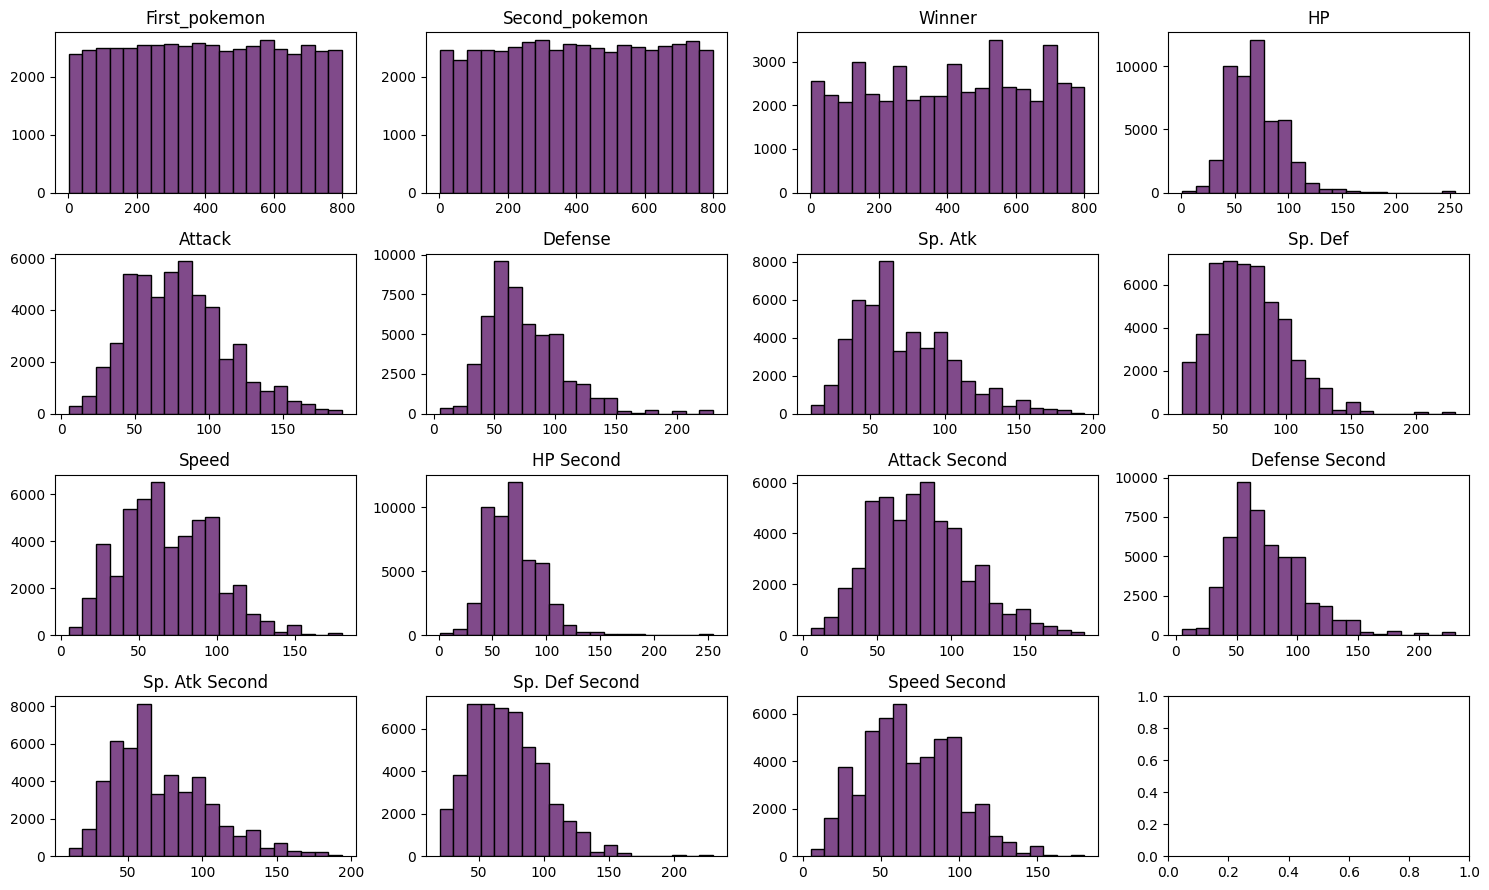

In [7]:
# Estraiamo i dati numerici dal dataframe
numerical_dataset: pd.DataFrame = dataset_1v1_fights.select_dtypes(include=np.number)

# Creiamo un bel color palette perché si
cmap: sb.palettes.color_palette = sb.diverging_palette(300, 60, s=50, l=40, n=10)
bar_color = cmap[0]

fig, axis = plt.subplots(4, 4, figsize=(15, 9))
axis = axis.flatten()
for i, label in enumerate(numerical_dataset.columns):
    axis[i].hist(numerical_dataset[label], bins=20, color=bar_color, edgecolor='black')
    axis[i].set_title(label)
fig.tight_layout()

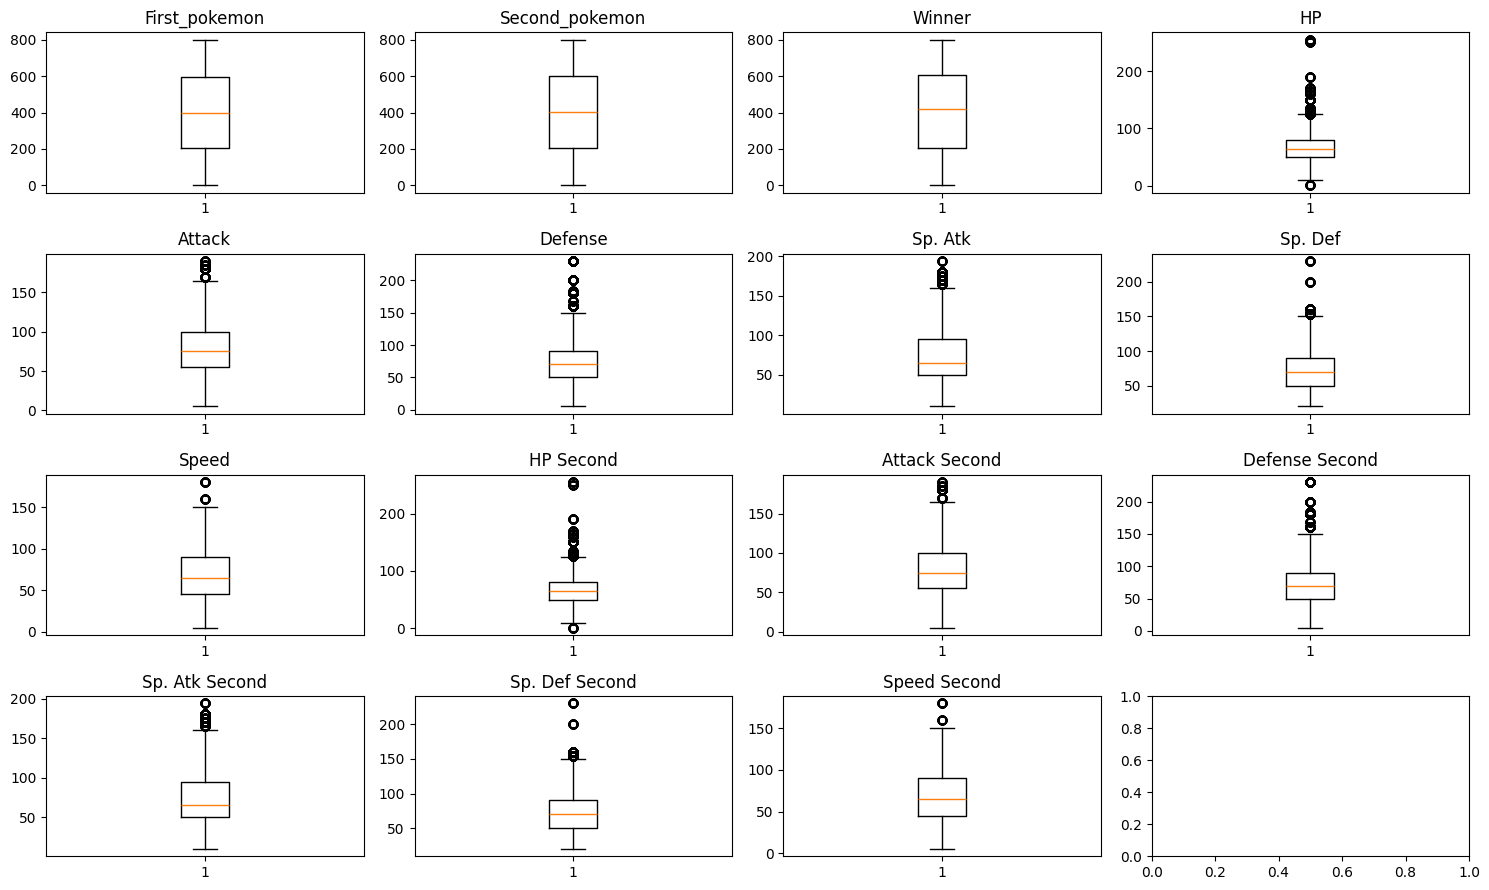

In [8]:
fig, axis = plt.subplots(4, 4, figsize=(15, 9))
axis = axis.flatten()
for i, label in enumerate(numerical_dataset.columns):
    axis[i].boxplot(numerical_dataset[label])
    axis[i].set_title(label)
fig.tight_layout()

## Codifica dei dati

In [9]:
## Codifica delle variabili categoriche
# Rimpiazzo dei tipi NaN con None
dataset_1v1_fights.fillna('None', inplace=True)
# Rimpiazzo dell id del vincitore con 0 se vince il primo, 1 se vince il secondo
dataset_1v1_fights.loc[dataset_1v1_fights['Winner'] == dataset_1v1_fights['First_pokemon'], 'Winner'] = 0
dataset_1v1_fights.loc[dataset_1v1_fights['Winner'] == dataset_1v1_fights['Second_pokemon'], 'Winner'] = 1
dataset_1v1_fights.drop(columns=['First_pokemon', 'Second_pokemon'], inplace=True)
# Otteniamo le label delle variabili categoriche
labels_categoriche: list[str] = ['Type 1', 'Type 2', 'Type 1 Second', 'Type 2 Second', 'Legendary', 'Legendary Second']
# Preprocessing delle variabili categoriche e numeriche
preprocessor: ColumnTransformer = ColumnTransformer([
    ("numeric", StandardScaler(), dataset_1v1_fights.select_dtypes(include=np.number).columns),
    ("categorical", OneHotEncoder(drop='first', sparse_output=False), labels_categoriche),
], remainder='drop')
# Ricostruzione del dataset
dataset_encoded: pd.DataFrame = pd.DataFrame(
    preprocessor.fit_transform(dataset_1v1_fights),
    columns=preprocessor.get_feature_names_out(dataset_1v1_fights.columns)
)

In [10]:
X: pd.DataFrame = dataset_encoded.drop(columns=['numeric__Winner']).select_dtypes(include=np.number)
y: pd.DataFrame = dataset_encoded['numeric__Winner']

lasso_model: Lasso = Lasso(alpha=10e-4)
lasso_model.fit(X, y)
new_series: pd.Series = pd.Series(lasso_model.coef_, X.columns)
dataset_encoded = dataset_encoded[new_series[new_series > 0.05].index]
dataset_encoded

,numeric__Attack Second,numeric__Speed Second,categorical__Type 1_Psychic,categorical__Type 2_Ghost,categorical__Type 1 Second_Dark,categorical__Type 1 Second_Ghost,categorical__Type 1 Second_Ground,categorical__Type 1 Second_Normal,categorical__Type 2 Second_Ghost,categorical__Type 2 Second_Steel
0,-0.278747,-0.284429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.541496,1.364588,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.124489,-0.971519,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.263832,-0.696683,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-2.129841,-2.173926,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
49995,-1.204294,-0.284429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49996,-0.741521,-0.284429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49997,1.109574,0.746207,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
49998,-1.358552,-0.799746,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Pulizia dei dati

## Creazione di dati aggiuntivi

# Variabili
X = correlation_dataset

y = dataset\['exam_score'\]

<Axes: >

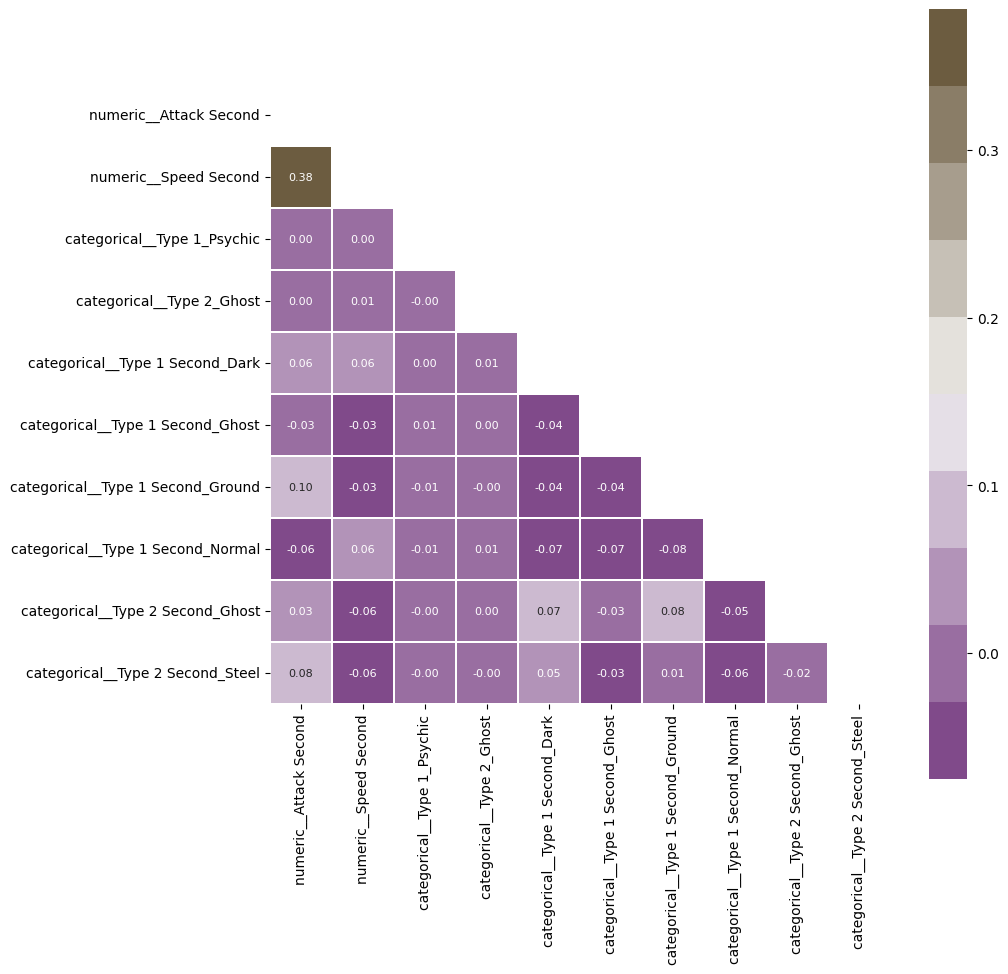

In [11]:
numerical_dataset_correlation: pd.DataFrame = dataset_encoded.corr()
# Create an upper triangular mask to avoid displaying the same data twice
mask: np.array = np.zeros_like(numerical_dataset_correlation, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Plot the correlation between the variables
plt.figure(figsize=(10, 10))
sb.heatmap(numerical_dataset_correlation, mask=mask, annot=True, square=True, linewidths=0.1, cmap=cmap, fmt=".2f", annot_kws={"fontsize":8})

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
linear_model: Pipeline = Pipeline([
    ('linear', LinearRegression())
])

linear_model.fit(X_train, y_train)
score_lin: float = linear_model.score(X_test, y_test)

print(f"Linear score: {score_lin}")

Linear score: 0.4917449909146828


In [29]:
# polynomial_model: Pipeline = Pipeline([
#     ("poly", PolynomialFeatures(include_bias=False)),
#     ("regr", LinearRegression())
# ])
# polynomial_model.fit(X_train, y_train)
# score_poly: float = polynomial_model.score(X_test, y_test)

# print(f"Polynomial score: {score_poly}")

In [ ]:
polynomial_model: Pipeline = Pipeline([
    ("poly", PolynomialFeatures(include_bias=False, degree=2)),
    ("regr", LinearRegression())
])
polynomial_model.fit(X_train, y_train)
score_poly: float = polynomial_model.score(X_test, y_test)

print(f"Polynomial score: {score_poly}")